Take a look at the [repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) for more information

# Install

In [34]:
import os

os.chdir('/content')
!rm -r /CycleGAN-VAE-NST/
!git clone https://github.com/davexhardware/CycleGAN-VAE-NST

rm: cannot remove '/CycleGAN-VAE-NST/': No such file or directory
fatal: destination path 'CycleGAN-VAE-NST' already exists and is not an empty directory.


In [70]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 359 bytes | 179.00 KiB/s, done.
From https://github.com/davexhardware/CycleGAN-VAE-NST
   6f7c29e..ba50eae  master     -> origin/master
Updating 6f7c29e..ba50eae
Fast-forward
 models/networks.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [58]:
import os
os.chdir('/content/CycleGAN-VAE-NST/')
!rm -r checkpoints/

In [37]:
!pip install -r requirements.txt

# Datasets

Use your own dataset by creating the appropriate folders and adding in the images.

-   Create a dataset folder under `/dataset` for your dataset.
-   Create subfolders `testA`, `testB`, `trainA`, and `trainB` under your dataset's folder. For our experiment, we're going to extract the tensors of the images from zip files.

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!cd /content/CycleGAN-VAE-NST
#!rm -r trainB
#!rm -r trainA
!unzip -d ./ -o /content/drive/MyDrive/trainA_pt_16_128.zip
!unzip -d ./ -o /content/drive/MyDrive/onepiece_pt.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: ./onepiece_pt/Jinbei_1.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_10.png.pt  
  inflating: ./onepiece_pt/Jinbei_100.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_101.jpeg.pt  
  inflating: ./onepiece_pt/Jinbei_102.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_103.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_104.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_105.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_106.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_106.png.pt  
  inflating: ./onepiece_pt/Jinbei_107.png.pt  
  inflating: ./onepiece_pt/Jinbei_108.png.pt  
  inflating: ./onepiece_pt/Jinbei_109.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_11.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_110.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_111.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_112.jpg.pt  
  inflating: ./onepiece_pt/Jinbei_113.png.pt  
  inflating: ./onepiece_pt/Jinbei_114.png.pt  
  inflating: ./onepiece_pt/Jinbei_115.jpg.pt  
  inflating: 

In [65]:
!rm -r ./trainB_pt_16_128
!ls ./onepiece_pt/ | wc -l

rm: cannot remove './trainB_pt_16_128': No such file or directory
7603


In [5]:
# prompt: i want to pick 2k random files from ./trainA_pt_16_128 and move them to ./datasets/trainA

import os
import random
import shutil
# Define source and destination directories
source_dir = './datasets/img_align_celeba_pt'
dest_dir = './datasets/trainA'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Get a list of all files in the source directory
files = os.listdir(source_dir)

# Randomly select 2000 files
num_files_to_move = 2000
if len(files) < num_files_to_move:
    print(f"Warning: Only {len(files)} files found in {source_dir}. Moving all of them.")
    num_files_to_move = len(files)

random_files = random.sample(files, num_files_to_move)

# Move the selected files to the destination directory
for file in random_files:
    source_path = os.path.join(source_dir, file)
    dest_path = os.path.join(dest_dir, file)
    shutil.copy(source_path, dest_path)

print(f"Copied {num_files_to_move} random files from {source_dir} to {dest_dir}")


Copied 2000 random files from ./datasets/img_align_celeba_pt to ./datasets/trainA


In [66]:
import os
import random
def move_train_to_test(train_dir, test_dir, num_files):
  if os.path.exists(train_dir):
    images = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]
    random.shuffle(images)
    images_to_move = images[num_files:]
    if not os.path.exists(test_dir):
        os.mkdir(test_dir)
    for image in [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]:
      if image not in images_to_move:
          os.rename(os.path.join(train_dir, image), os.path.join(test_dir, image))

!cd /workspace/CycleGAN-VAE-NST
!rm -r ./datasets/trainA
!cp -r ./trainA_pt_16_128/ ./datasets/trainA
## COMMENT OUT THIS BLOCK IF YOU WANT TO KEEP ALL IMAGES
path='/workspace/CycleGAN-VAE-NST/datasets/trainA'
pathdst='/workspace/CycleGAN-VAE-NST/datasets/testA'
testA_size=100
move_train_to_test(path, pathdst, testA_size)

!rm -r ./datasets/trainB
!cp -r ./onepiece_pt/ ./datasets/trainB
path='/workspace/CycleGAN-VAE-NST/datasets/trainB'
pathdst='/workspace/CycleGAN-VAE-NST/datasets/testB'
testB_size=100
move_train_to_test(path, pathdst, testB_size)

/bin/bash: line 1: cd: /workspace/CycleGAN-VAE-NST: No such file or directory


In [74]:
!ls ./datasets/trainB  | wc -l
!ls ./datasets/trainA  | wc -l

2000
2000


# Training


Change the `--dataroot` and `--name` to your own dataset's path and model's name. Use  `--batch_size` to change the batch size.

In [53]:

import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("cuDNN enabled:", torch.backends.cudnn.enabled)
print("cuDNN version:", torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else "Not available")
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

x = torch.randn(1, 1, 32, 32, device="cuda")  # Random tensor on GPU
conv = torch.nn.Conv2d(1, 1, kernel_size=3).cuda()  # Simple Conv2D layer
with torch.backends.cudnn.flags(enabled=True):
    output = conv(x)
print("cuDNN acceleration is working!" if torch.backends.cudnn.enabled else "cuDNN is not being used.")

PyTorch version: 2.5.1+cu124
CUDA available: True
cuDNN enabled: True
cuDNN version: 90100
CUDA Device Name: Tesla T4
cuDNN acceleration is working!


In [ ]:
!python train.py --dataroot ./datasets --name portraits2op --lambda_identity 0 --latent_dim 256 --init_type xavier --norm bn --netG RESVAE --dataset_mode tensor --crop_size 128 --batch_size 16 --verbose --n_epochs 50 --n_epochs_decay 50 --display_id -1 --beta1 0.65 --lambda_A 9.0 --gan_mode vanilla --lambda_kl 1.1 --lambda_rec 0.9 --lr 1e-4 --continue_train --epoch_count 10

----------------- Options ---------------
               batch_size: 16                            	[default: 1]
                    beta1: 0.65                          	[default: 0.5]
          checkpoints_dir: ./checkpoints                 
           continue_train: True                          	[default: False]
                crop_size: 128                           	[default: 256]
                 dataroot: ./datasets                    	[default: None]
             dataset_mode: tensor                        	[default: unaligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256      


Once your model has trained, copy over the last checkpoint to a format that the testing model can automatically detect:

Use `cp ./checkpoints/<MODELNAME>/latest_net_G_A.pth ./checkpoints/<MODELNAME>/latest_net_G.pth` if you want to transform images from class A to class B and `cp ./checkpoints/horse2zebra/latest_net_G_B.pth ./checkpoints/horse2zebra/latest_net_G.pth` if you want to transform images from class B to class A.


### While training
Sometimes, run this to clean previous saved models

In [ ]:
import re

os.chdir('/workspace/CycleGAN-VAE-NST/checkpoints/portraits2op/')
def remove_files_with_regex(directory, pattern):
    for filename in os.listdir(directory):
        if re.match(pattern, filename):
            os.remove(os.path.join(directory, filename))

pattern = r'[0-9]+\_net\_[GD]\_[AB]\.pth'
remove_files_with_regex(os.getcwd(), pattern)

# Testing

-   `python test.py --dataroot datasets/horse2zebra/testA --name horse2zebra_pretrained --model test --no_dropout`

Change the `--dataroot` and `--name` to be consistent with your trained model's configuration.

> from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix:
> The option --model test is used for generating results of CycleGAN only for one side. This option will automatically set --dataset_mode single, which only loads the images from one set. On the contrary, using --model cycle_gan requires loading and generating results in both directions, which is sometimes unnecessary. The results will be saved at ./results/. Use --results_dir {directory_path_to_save_result} to specify the results directory.

> For your own experiments, you might want to specify --netG, --norm, --no_dropout to match the generator architecture of the trained model.

In [ ]:
!python test.py --dataroot datasets/horse2zebra/testA --name horse2zebra_pretrained --model test --no_dropout

# Visualize

In [ ]:
!pip install matplotlib
!ls ./checkpoints/portraits2op/web/images/


epoch001_fake_A.png  epoch001_real_A.png  epoch002_fake_A.png  epoch002_real_A.png
epoch001_fake_B.png  epoch001_real_B.png  epoch002_fake_B.png  epoch002_real_B.png
epoch001_idt_A.png   epoch001_rec_A.png   epoch002_idt_A.png   epoch002_rec_A.png
epoch001_idt_B.png   epoch001_rec_B.png   epoch002_idt_B.png   epoch002_rec_B.png


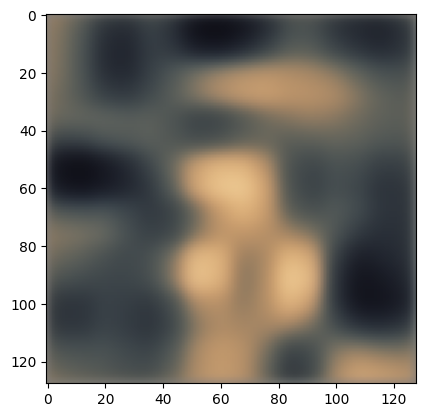

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./checkpoints/portraits2op/web/images/epoch002_fake_B.png')
plt.imshow(img)

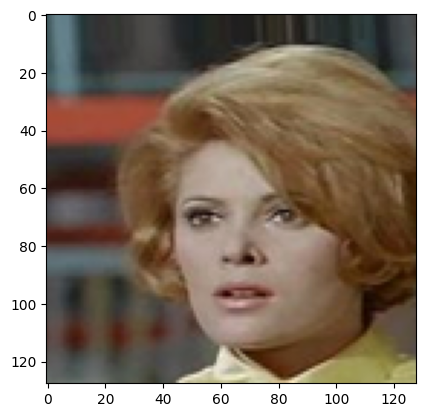

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./checkpoints/portraits2op/web/images/epoch002_real_A.png')
plt.imshow(img)